# DBSCAN

The overall complexity of DBSCAN is O(n²) in the worst case.

Motivation for **density-based clustering** (https://towardsdatascience.com/a-practical-guide-to-dbscan-method-d4ec5ab2bc99):

Two popular types of clustering methods are: partitioning and hierarchical methods.
- **Partitioning method**: partitions the dataset to k (the main input of the methods) number of groups (clusters).The most well-known Partitioning method is K-means.The partition methods have some significant drawbacks: you should know beforehand into how many groups you want to split the database (the K value). Another important drawback is that K-means does not perform well on finding non-convex/non-spherical shapes of clusters and K-means is sensitive to noise data.
- **Hierarchical method** creates a Hierarchical visual representation for the data using a special tree. In contradiction to K-means, you don’t need to decide what should be the number of clusters, but it also has some serious drawbacks: it isn’t suitable for big datasets, has high computational complexity, you need to choose the metric for merging the clusters (linkage) that affects the clustering results. 

As we can see the main disadvantages of partitioning and hierarchical methods are: handling noise and getting bad results with finding clusters of nonspherical shape.
**The DBSCAN clustering method is able to represent clusters of arbitrary shape and to handle noise.**

**DBSCAN**

Differing groups of points by their density is the main idea of the DBSCAN.

The DBSCAN groups together points with a dense neighborhood into clusters: A point will be considered as crowded if it has many other neighbors points near it. The DBSCAN finds these crowded points and places them and their neighbors in a cluster.

In general, ε should be chosen as small as possible.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from dbscan import DBSCAN

import networkx as nx
import operator

import sys
sys.path.insert(0,'../code/')
from utils.utils import train_data_loader, data_pre_processing, create_train_test, feature_selection_univ

## Load data

In [2]:
import os

# Get the current working directory
current_directory = os.getcwd()

print("Current working directory:", current_directory)

Current working directory: /home/erika/eth_fraud_detection/notebook


In [3]:
data = train_data_loader()

/home/erika/eth_fraud_detection/notebook/../code/utils/utils.py:69: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  eth_20170702 = pd.read_csv("https://s3.eu-central-2.wasabisys.com/ethblockchain/eth_trans_20170702.csv")


# Data Preprocessing

In [4]:
df = data_pre_processing(data)

/home/erika/eth_fraud_detection/notebook/../code/utils/utils.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_drop.drop(columns=['check_hash'], inplace=True)
/home/erika/eth_fraud_detection/notebook/../code/utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_missing_date.drop(['receipt_status', 'max_fee_per_gas', 'max_priority_fee_per_gas', 'transaction_type','receipt_contract_address'],axis=1,inplace=True)


In [21]:
# Drop target features (comments, flags)
# Keep only numeric features
# Keep only numeric features, divide features form target variable
Xtrain, ytrain = create_train_test(df)

# Drop features as per univariate selection
Xtrain = feature_selection_univ(Xtrain)

In [22]:
# Apply standard scaler

X = StandardScaler().fit_transform(Xtrain)

In [23]:
ytrain['transaction_flag'].value_counts()

transaction_flag
0    777681
1        21
Name: count, dtype: int64

## Apply the standard Scaler

## Fit the first DBSCAN algo

In [60]:
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, jaccard_score

eps = [0.2, 0.3, 0.5, 0.7]
min_samples = [10000, 5000, 1000, 500, 200, 100]

dbscan_performance = dict()
for e in eps:    
    for n in min_samples:

       ## Fit the DBSCAN
       labels, core_samples_mask = DBSCAN(X,eps=e, min_samples=n)

       #df_labels = np.ravel(df_labels)
       
       #silhouette_avg = silhouette_score(X, df_labels)
       #nmi = normalized_mutual_info_score(ytrain, df_labels)
       #jaccard_similarity = jaccard_score(ytrain, df_labels) 
       #print(silhouette_avg)

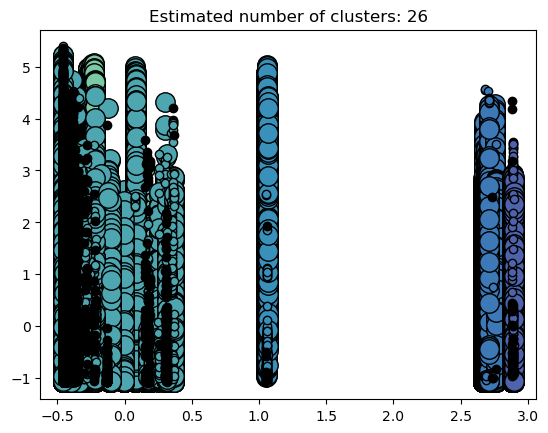

In [61]:
import matplotlib.pyplot as plt


n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.savefig('dbscan-output')


### Check if the anomalies are represented by a specific cluster

In [28]:
df_labels = pd.DataFrame(labels)
df_labels.columns = ['DBSCAN_labels']
df_labels.head()

,DBSCAN_labels
0,7
1,7
2,7
3,7
4,7


In [29]:
# Merge X, y and DBSCAN labels
Xtrain.reset_index(drop=True, inplace=True)
ytrain.reset_index(drop=True, inplace=True)
train_data_dbscan_labels = pd.merge(Xtrain,ytrain,left_index=True,right_index=True)
train_data_dbscan_labels = pd.merge(train_data_dbscan_labels,df_labels,left_index=True,right_index=True)
train_data_dbscan_labels.head()

,nonce,transaction_index,value,gas,receipt_cumulative_gas_used,receipt_gas_used,gas_price_unit,value_div_gas,from_address_count,to_address_count,block_count,in_degree_adr_from,transaction_flag,DBSCAN_labels
0,13811,1,1.063354e+19,21000.0,42000.0,21000.0,2.428571e+06,5.063592e+14,3004,1,3,32,0,7
1,13812,0,6.415838e+18,21000.0,21000.0,21000.0,2.428571e+06,3.055161e+14,2789,1,3,30,0,7
2,6,2,1.854957e+18,21000.0,63000.0,21000.0,2.380952e+06,8.833128e+13,1,1,3,0,0,7
3,57039,4,0.000000e+00,300000.0,191170.0,36848.0,1.666667e+05,0.000000e+00,900,4416,96,1,0,7
4,0,40,7.964769e+17,90000.0,2378638.0,21000.0,2.333333e+05,8.849744e+12,3,1,96,0,0,7


In [62]:
aggreagation={
    'transaction_flag':['count','sum']
}

dbscan_summary = train_data_dbscan_labels.groupby('DBSCAN_labels').agg(aggreagation)
dbscan_summary.index
dbscan = pd.DataFrame(data=dbscan_summary.values, index=dbscan_summary.index, columns=['number_of_transaction','anomalous_transaction'])
dbscan['pct_numb_of_transaction'] = dbscan['number_of_transaction']/len(train_data_dbscan_labels)
dbscan['pct_anomalous_transaction'] = dbscan['anomalous_transaction']/dbscan['number_of_transaction']
dbscan.sort_values(by=['number_of_transaction'],inplace=True, ascending=False)
dbscan

,number_of_transaction,anomalous_transaction,pct_numb_of_transaction,pct_anomalous_transaction
DBSCAN_labels,,,,
7,383492,21,0.493109,0.000055
-1,173127,0,0.222614,0.000000
9,70512,0,0.090667,0.000000
3,46360,0,0.059612,0.000000
4,39856,0,0.051248,0.000000
1,26282,0,0.033794,0.000000
5,12158,0,0.015633,0.000000
6,6135,0,0.007889,0.000000
2,5453,0,0.007012,0.000000
